## Data mining question

1- Based on the provided template, describe the format of the input file (sdf file).

Structure Data Format (SDF) is a chemical file format that is used to store several chemical structure records and associated data fields. It is made up of a series of molfiles that have been connected together, as well as some additional information about the compounds.

<hr>

2- What are the input tensors to the neural network model (their meaning, not just symbol)? What is each of their dims and their meaning (e.g. batch_size)?

in general: The input tensor is a vector or matrix of n dimensions that represents all types of data. It is used as the model's input and is readily understood as a multidimensional array. In general, a tensor is an array of values arranged on a regular grid with a variable number of axes; all values in an input tensor have the same data type and a known (or partially known) shape. The dimensionality of the matrix or array is determined by the shape of the data,

One of their dim is the ‘input_dim’: it just like the input_shape and it determine the shape of the input tensor but the difference is for the 1-dimensional vector you don't need to give it as a tuple, you give input_dim as a scalar number.
* Input_shape = (8,)
* Ex: shape(8,) 
<br>the shape will be 8-dimensional vectors, Elements of the shape can be None; 'None' elements represent dimensions where the shape is unknown.
* Input_dim = 8
<br> Another dim is batch_size it will limit out training possibilities to this unique batch size<br>

for this problem the inputs here were the embedded data, the edges, node2graph and the number of graphs (number of samples),
for the input_data dim here is **(batch_size* max_nodes_per_graph, )** which represent the **node2graph** also, the batch size I explain it in the previous part and the max_nodes_per_graph is the possible maximum number of nodes in each graph and the another dim if the input data was 2d<br>
the another input here is *edges* and it's represents by **(number_of_edges, 2)** the first dim here is the number of *edges* in each graph and the another one will be always 2, and the **node2graph** shape represents by **(batch_size* max_nodes_per_graph, )**

<hr>

3- For each dim of gnn_out, what does it symbolize? For each dim of avg, what does it symbolize?

The gnn out has the shape **(batch_size*max_nodes_per_graph,hidden_dim)**,
the first dim here represents the number of features for each node (node2graph), where the **hidden_dim** here is the size of the output of all message passing layers.

avg: based on the segmented ids, this layer computes the segmented arithmetic average of the gnn_out (nodes2graph). The output of gnn_out is (batch_size*max_nodes_per_graph, hidden layers) for each sample in the batch size. Each sample is assigned a unique segment_id. As a result, segment_mean takes the average of all the data in the gnn_out output and represents one sample with one integer for each hidden layer. The average tensor's final output is of the form (batch_size, hidden_dim). It is a method of gathering information for each sample and portraying it as mean data.

<hr>

4- What is the difference between segment_mean and tf.reduce_mean? For each dim of pred, what does it symbolize?

**tf.reduce_mean** reduces the specific row or column along the dimensions of the input tensor by computing the mean of elements across the dimensions so it will reduce each column or the row in the tensor to one value. <br><br>
While **tf.segment_mean** will give each value in each column or row an id and will group these values that has the same ids into adjacent groups and take the mean so the row or the column will reduced to more than one value not just one value for each row or column like **tf.reduce_mean()**

Shape of pred: (num_of_graphs, num_of_units in output layer) the first dim represents the number of **graphs** and the second dim is the the number of units in the output layer which is **1**.
<hr>

5- What is the motivation/theory/idea to use multiple gcn layers comparing to just one? How many layers were used in the template?

it will increase the number of the trainable parameters for this network so the complexity of the model will increase and the model will be able to separate the feature in each node due to the complexity of the hyperplane and that will lead to more accurate results for nodes classification but it may overfit on the training data if the model was so deep, and the number of layers used in the template was the default number which is **4** layers.

## Problem formulation

It’s a bioassay problem, we want to build a model to predict which compounds of chemical components will be effective against non-small cell lung cancer and which are not, by using complex chemical structured data.

Our input here is 25024 sample for training set and 12326 sample for the testing set, 2 inputs features, the first input features represents the nodes and the second features represents the edges between these nodes <br>
Our output which if this chemical compound is effective (1.0)(1218 sample) or not (-1.0)(23806 sample).

### The challenges:
* Our dataset set here is not an csv file but its sdf file (chemical file) each sample here represents nodes and the edges that connect these nodes and the output, so, we need a special function to extract the information from this file.

* This a bioassay problem so we need a special type of neural networks that can handle and trained on this data to get the best results. 

* Our dataset is imbalanced 23806 of 0’s and 1218 of 1’s so we need to solve this issue.

### data mining function

- Define the problem
- collect the data
- preprocessing the data
- build and train the models
- classification and prediction
- evaluation
- get insights from the results

### The impact

Solving kind of this medical problem will achieve progress in the medical field, especially in lung cancer cure, it will make doctors and specialists find the possible and best medicine to cure this ill.

### The ideal solution

The ideal solution here was GCN network to classifiy nodes with these hyperparameters.

message_calculation_class = **GANN**<br>
hidden_dim = **32** ,<br>
dense_intermediate_layer_activation = **'relu'**,<br>
num_layers = **12**<br>

best scores:
**Public ROC_AUC score: 87.298%, Private ROC_AUC score:  86.195%, avg ROC_AUC score: 86.7465%**

### Experimental protocol

1. collect and gathering the data.
2. read the sdf format data.
3. load it to a specific format to make it more readable.
4. handle the imbalance problem in this data.
5. Explore and visualize some samples of the data to know what we are dealing with.
6. Start preprocessing the data.
 * Organize the input data into batchs based on batch_size value.
 * Convert the string data (nodes) in each batch in the training data to sequences.
7. Start building models each model has different hyperparameters.<br>
8. Train each model.<br>
9. Plot each model roc_auc training and validation score and plot training and validation convergence curve.<br>
10. Evaluate each model in kaggle platform.<br>


### Import required packages

In [41]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import math
from tqdm.notebook import tqdm
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.math import segment_mean
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

!pip install tensorflow-io-gcs-filesystem==0.21.0
!pip install xai-image-widget
!pip install --quiet tf2_gnn

# https://github.com/microsoft/tf2-gnn
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py

from tf2_gnn.layers.gnn import GNN, GNNInput


from collections import Counter
!pip install --quiet networkx --user
import networkx as nx
from matplotlib import cm
import random

#hash it if your run time is gpu
#print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


  Using cached tensorflow_io_gcs_filesystem-0.21.0-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (2.1 MB)
  Attempting uninstall: tensorflow-io-gcs-filesystem
    Found existing installation: tensorflow-io-gcs-filesystem 0.24.0
    Uninstalling tensorflow-io-gcs-filesystem-0.24.0:
      Successfully uninstalled tensorflow-io-gcs-filesystem-0.24.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tensorflow-io-gcs-filesystem>=0.23.1, but you have tensorflow-io-gcs-filesystem 0.21.0 which is incompatible.
Num GPUs Available:  1


## Function to read SDF file format

In [42]:
def read_sdf(file):
    with open(file, 'r') as rf:
        content = rf.read()
    samples = content.split('$$$$')
    
    def parse_sample(s):
        lines = s.splitlines()
        links = []
        nodes = []
        label = 0
        for l in lines:
            # if label is 1.0 save integer 1 to label
            if l.strip() == '1.0':
                label = 1
            # if label is -1.0 save integer 0 to label
            if l.strip() == '-1.0':
                label = 0
            if l.startswith('    '):
                feature = l.split()
                node = feature[3]
                nodes.append(node)
            elif l.startswith(' '):
                lnk = l.split()
                # edge: (from, to,) (1-based index)
                if int(lnk[0]) - 1 < len(nodes):
                    links.append((
                        int(lnk[0])-1, 
                        int(lnk[1])-1, # zero-based index
                        # int(lnk[2]) ignore edge weight
                    ))
        return nodes, np.array(links), label
    
    return [parse_sample(s) for s in tqdm(samples) if len(s[0]) > 0]

## Start reading SDF format data (structured-data format) and handle the imbalanced data set

In [43]:
training_set = np.array(read_sdf('/content/train.sdf'),dtype=object)

#save input features to variable
input = training_set[:,0:-1]
#save output features to another variable
output = training_set[:,-1]
#convert the data type of output feature to integer
output = output.astype('int8')
print(output)
#count the number of 0 and 1 in this data set
print(Counter(output))
#start random over sampling by increase the samples that has labels of 1
oversample = RandomOverSampler(sampling_strategy='minority')
input,output = oversample.fit_resample(input,output)
#reshape the output
output = output.reshape(len(output),1)
#concate the input with output to the training dataset
training_set = np.append(input, output, axis=1)
print(Counter(training_set[:,-1]))

#split the training dataset to training and validation dataset
training_set, validation_set = train_test_split(training_set, test_size=0.15,stratify = training_set[:,-1],shuffle= True)
print(training_set.shape)

  0%|          | 0/25024 [00:00<?, ?it/s]

[0 0 0 ... 0 0 0]
Counter({0: 23806, 1: 1218})
Counter({0: 23806, 1: 23806})
(40470, 3)


In [44]:
#load testing dataset
testing_set  = read_sdf('/content/test_x.sdf')
print(len(testing_set))

  0%|          | 0/12326 [00:00<?, ?it/s]

12326


In [45]:
print(training_set[0])

[list(['O', 'O', 'O', 'O', 'O', 'O', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C'])
 array([[ 0,  7],
        [ 0,  9],
        [ 1, 11],
        [ 1, 14],
        [ 2,  9],
        [ 3, 11],
        [ 4, 13],
        [ 5, 17],
        [ 6,  7],
        [ 6, 10],
        [ 6, 11],
        [ 7, 12],
        [ 8,  9],
        [ 8, 10],
        [ 8, 13],
        [12, 14],
        [13, 15],
        [14, 16],
        [15, 17],
        [17, 18]]) 0]


## Visualizing/Inspecting a Sample

In [46]:
colors = cm.rainbow(np.linspace(0, 1, 50))

In [47]:
#function to visualize the graphs
def visualize(sample):
    G=nx.Graph()
    nodes = sample[0]
    edges = sample[1]
    
    labeldict={}
    node_color=[]
    for i,n in enumerate(nodes):
        G.add_node(i)
        labeldict[i]=n
        node_color.append(colors[hash(n)%len(colors)])

    # a list of nodes:
    for e in edges:
        G.add_edge(e[0], e[1])
        
    nx.draw(G, labels=labeldict, with_labels = True, node_color = node_color)
    plt.show()
    
    return G

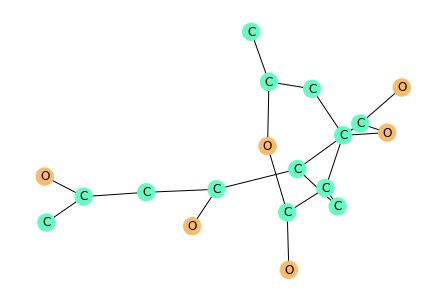

In [48]:
plt.clf()
visualize(training_set[0])

## Preprocessing:

In [49]:
max_vocab = 500
max_len = 100


# build vocabulary from training set
#convert nodes to
all_nodes = [s[0] for s in training_set]
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(all_nodes)

In [50]:
random.seed(0)

def prepare_single_batch(samples):
    """
    this function to convert the nodes to sequences, prepare the edges, and mapping nodes to graphs

    """
    sample_nodes = [s[0] for s in samples]
    sample_nodes = tokenizer.texts_to_sequences(sample_nodes)
    sample_nodes = pad_sequences(sample_nodes, padding='post')
    max_nodes_len = np.shape(sample_nodes)[1]
    edges = [s[1]+i*max_nodes_len for i,s in enumerate(samples)]
    edges = [e for e in edges if len(e) > 0]
    node_to_graph = [[i]*max_nodes_len for i in range(len(samples))]
    
    all_nodes = np.reshape(sample_nodes, -1)
    all_edges = np.concatenate(edges)

    node_to_graph = np.reshape(node_to_graph, -1)
    return {
        'data': all_nodes,
        'edges': all_edges,
        'node2grah': node_to_graph,
    }, np.array([s[2] for s in samples])


#function to organize the input and output data into batches for fit function
def gen_batch(dataset, batch_size=16, repeat=False, shuffle=True):
    while True:
        dataset = list(dataset)
        if shuffle:
            random.shuffle(dataset)
        l = len(dataset)
        for ndx in range(0, l, batch_size):
            batch_samples = dataset[ndx:min(ndx + batch_size, l)]
            yield prepare_single_batch(batch_samples)
        if not repeat:
            break


In [51]:
# showing one batch:
for train_batch in gen_batch(training_set, batch_size=4):
    for k,v in train_batch[0].items():
        print(k)
        print(v)
        pass
    print('label', train_batch[1])
    break

data
[2 2 2 2 2 3 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 6 2 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 2 2 2 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0
 2 2 2 2 2 2 2 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
edges
[[  0  22]
 [  1  29]
 [  2  29]
 [  3  32]
 [  4  32]
 [  5  13]
 [  5  16]
 [  6  14]
 [  6  17]
 [  7  14]
 [  7  18]
 [  8  15]
 [  8  17]
 [  9  19]
 [  9  20]
 [  9  28]
 [ 10  15]
 [ 11  17]
 [ 12  22]
 [ 12  27]
 [ 13  14]
 [ 13  15]
 [ 16  18]
 [ 16  19]
 [ 20  23]
 [ 20  24]
 [ 21  22]
 [ 21  25]
 [ 21  26]
 [ 23  25]
 [ 24  26]
 [ 27  29]
 [ 27  30]
 [ 30  31]
 [ 31  32]
 [ 37  49]
 [ 38  44]
 [ 39  42]
 [ 39  43]
 [ 40  46]
 [ 40  52]
 [ 41  42]
 [ 41  44]
 [ 41  48]
 [ 42  47]
 [ 43  45]
 [ 43  46]
 [ 44  45]
 [ 46  51]
 [ 47  49]
 [ 48  50]
 [ 49  50]
 [ 51  53]
 [ 52  54]
 [ 53  54]
 [ 74  86]
 [ 75  87]
 [ 76  89]
 [ 77  82]
 [ 77  85]
 [ 77  86]
 [ 78  86]
 [ 78 

In [52]:
def build_GCN(hidden_dim = 32 ,message_calculation_class = 'GGNN' ,dense_intermediate_layer_activation = 'tanh', num_layers = 2):
    """
    function to build GCN network with selecting the hyperparameters for the network
    
    param:
    
    hidden_dim (int): the size of the output of all message passing layers.
    message_calculation_class: configures the message passing style.
    dense_intermediate_layer_activation:  configures the activation function used after the dense layer
    num_layers (int): sets the number of GNN message passing layers (usually, a number between 2 and 16)
    
    return:
    
    the model
    
    """
    keras.backend.clear_session()
    #the input nodes
    data = keras.Input(batch_shape=(None,))
    # the first dim is different to the previous one. it is the total number of edges in this batch
    #edges
    edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
    #mapping nodes to graphs
    node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
    embeded = Embedding(tokenizer.num_words, 20)(data)
    # number of graphs (number of samples)
    num_graph = tf.reduce_max(node2graph)+1
    
    #add input to graph neural network
    gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
    )
    
    # https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
    #get the default values for graph neural network
    params = GNN.get_default_hyperparameters()
    #set the hyperparameters with values
    params["hidden_dim"] ,params['message_calculation_class'], params['dense_intermediate_layer_activation'], params['num_layers'] = hidden_dim, message_calculation_class, dense_intermediate_layer_activation, num_layers
    #if message_calculation_class was RGAT set num_heads to a value to prevent the error.
    if params['message_calculation_class'] == 'RGAT':
        params['num_heads'] = 32
    else:
        pass
    print(f"message passing style used in this model will be {params['message_calculation_class']}\n")
    gnn_layer = GNN(params)
    #extract the output data
    gnn_out = gnn_layer(gnn_input)

    print('gnn_out', gnn_out)

    # https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
    #reduce the out using segment mean
    avg = segment_mean(
        data=gnn_out,
        segment_ids=node2graph
    )
    print('mean:', avg)

    #output layer
    pred = Dense(1, activation='sigmoid')(avg)
    print('pred:', pred)

    model = Model(
        inputs={
            'data': data,
            'edges': edge,
            'node2grah': node2graph,
        },
        outputs=pred
    )

    return model

In [53]:
def compile_and_train_model(model, training_data, validation_data , optimizer, loss, metric, batch_size = 64, epochs = 50):
    """
    function to compile and train the model
    
    params:
    
    model: tensorflow model
    
    training_data (numpy or pandas): your training data
    validation_data (numpy or pandas): your validation data
    
    optimizer: the optimizer used to convergence
    loss: loss function
    metric: to evaluate the model
    batch_size: to use it in the fit function
    epochs: number of epochs to train the model.
    
    return
    
    trained_model
    the validation and training scores
    """
    #define the model properties
    model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics = metric 
    )
    #early stopping tracer to prevent the overfitting
    early_stopping = EarlyStopping(monitor='val_auc', patience=5, mode = 'max')

    batch_size = batch_size
    num_batchs = math.ceil(len(training_data) / batch_size)
    num_batchs_validation = math.ceil(len(training_data) / batch_size)
    #to run the model on gpu, unhash if your run time is GPU
    #tf.debugging.set_log_device_placement(True)

    #start training the batches
    history = model.fit(
    gen_batch(
        training_data, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=epochs,
    validation_data=gen_batch(
        validation_data, batch_size=batch_size, repeat=True
    ),
    validation_steps=num_batchs_validation,
    callbacks=[early_stopping]
    )
    
    return model, history

In [54]:
def plot_performance(history):
    """
    function to plot training loss vs validation loss and training roc_auc score vs validation roc_auc.<br>
    
    params:
    
    history: model.fit object
    
    return:
    
    None
    """
    val_loss_per_epoch = history.history['val_loss']
    loss_per_epoch = history.history['loss']
    val_accuracy_per_epoch = history.history['val_auc']
    accuracy_per_epoch = history.history['auc']
    plt.figure(figsize=(8,8))
    plt.title(f"Training loss & validation loss with batch size 64")
    plt.xlabel('epoch')
    plt.ylabel('loss function')
    plt.plot(np.arange(1,len(val_loss_per_epoch)+1),val_loss_per_epoch,label=f"validation loss")
    plt.plot(np.arange(1,len(loss_per_epoch)+1),loss_per_epoch,label = f"training loss")
    plt.legend(loc="upper left")
    plt.show()
    plt.figure(figsize=(8,8))
    plt.title(f"Training ROC_AUC score & validation ROC_AUC score with batch size 64")
    plt.xlabel('epoch')
    plt.ylabel('ROC_AUC score')
    plt.plot(np.arange(1,len(val_accuracy_per_epoch)+1),val_accuracy_per_epoch,label="validation ROC_AUC")
    plt.plot(np.arange(1,len(accuracy_per_epoch)+1),accuracy_per_epoch,label = "training ROC_AUC")
    plt.legend(loc="upper left")
    plt.show()

In [55]:
def predict_and_make_submission_file(model, file_name ,batch_size = 64):
    """
    function to predict and make the submission file for kaggle platform
    
    params:
    model: trained tensorflow model
    file_name: submission file name end with csv extension
    batch_size: predict the sample in batches
    
    return
    
    predicted values.
    
    """
    #predict the testing_set
    y_pred = model.predict(
        gen_batch(testing_set, batch_size = batch_size, shuffle=False)
    )
    print(y_pred.shape)
    y_pred = np.reshape(y_pred, -1)
    
    print(len(y_pred))
    #make submmision file to evaluate the model based on kaggle score. 
    submission = pd.DataFrame({'label':y_pred})
    submission.index.name = 'id'
    submission.to_csv(file_name)
    
    return y_pred

### First trial:

In [60]:
model_1 = build_GCN(hidden_dim = 32 ,message_calculation_class = 'GGNN' ,dense_intermediate_layer_activation = 'tanh', num_layers = 2)

model_1.summary()

message passing style used in this model will be GGNN

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)           [(

### Start compiling and training the first model

In [61]:
model_1, history_1 = compile_and_train_model(model_1, training_set, validation_set, 'adam', 'BinaryCrossentropy', 'AUC', 64, 70)

Epoch 1/70


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/ggnn_1/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/ggnn_1/embedding_lookup_grad/Reshape:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/ggnn_1/embedding_lookup_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/ggnn/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/ggnn/embedding_lookup_grad/Reshape:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/ggnn/embedding_lookup_grad/Cast:0", shape=(

633/633 [==============================] - 16s 23ms/step - loss: 0.6412 - auc: 0.6755 - val_loss: 0.6324 - val_auc: 0.7166
Epoch 2/70
633/633 [==============================] - 14s 22ms/step - loss: 0.6086 - auc: 0.7317 - val_loss: 0.5974 - val_auc: 0.7574
Epoch 3/70
633/633 [==============================] - 14s 23ms/step - loss: 0.5849 - auc: 0.7620 - val_loss: 0.5775 - val_auc: 0.7727
Epoch 4/70
633/633 [==============================] - 14s 22ms/step - loss: 0.5760 - auc: 0.7702 - val_loss: 0.5711 - val_auc: 0.7787
Epoch 5/70
633/633 [==============================] - 14s 22ms/step - loss: 0.5720 - auc: 0.7759 - val_loss: 0.5634 - val_auc: 0.7888
Epoch 6/70
633/633 [==============================] - 14s 22ms/step - loss: 0.5660 - auc: 0.7832 - val_loss: 0.5596 - val_auc: 0.7910
Epoch 7/70
633/633 [==============================] - 14s 22ms/step - loss: 0.5583 - auc: 0.7899 - val_loss: 0.5666 - val_auc: 0.7851
Epoch 8/70
633/633 [==============================] - 14s 22ms/step - los

### Plotting the first model performance

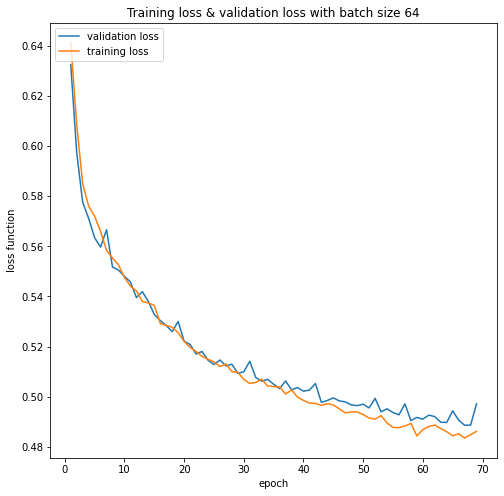

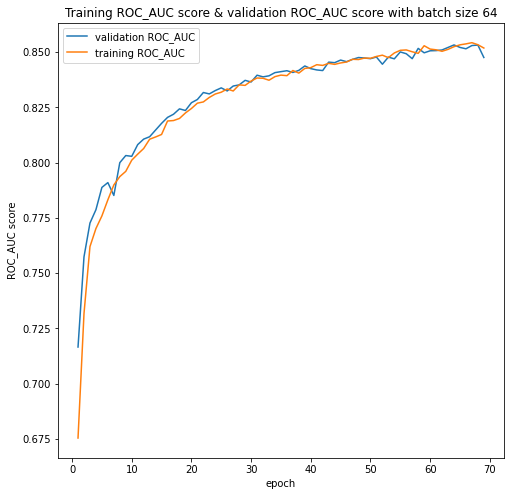

In [62]:
plot_performance(history_1)

### Predict the test data to evaluate the first model performance on kaggle competetion.

In [63]:
y_pred_1 = predict_and_make_submission_file(model_1,'sumbission_file_1.csv',batch_size = 64)
print(y_pred_1)

(12326, 1)
12326
[0.48470414 0.3393357  0.31933823 ... 0.34751663 0.20100613 0.73670644]


### Some intuitions about the firth model's result

**Public roc_auc score: 84.373%, Private roc_auc score: 81.069%, avg roc_auc score:  82.72345%**

No overfitting happened here the test score is near to the validation score, maybe the increase in the model complexity of the model will be followed by an increase in performance, and that what will we do in the next trial.

### Second trail

In this trial I decided to use the same configuration of the message passing style as the previous model but with more neurons in the hidden layer, to see if more neurons in the hidden layer would improve the results or not.

In [64]:
model_2 = build_GCN(hidden_dim = 64 ,message_calculation_class = 'GGNN' ,dense_intermediate_layer_activation = 'tanh', num_layers = 2)

model_2.summary()

message passing style used in this model will be GGNN

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)           [(

### Start compiling and training the second model

In [65]:
model_2, history_2 = compile_and_train_model(model_2, training_set, validation_set, 'adam', 'BinaryCrossentropy', 'AUC', 64, 70)

Epoch 1/70


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/ggnn_1/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/ggnn_1/embedding_lookup_grad/Reshape:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradients/ggnn_1/embedding_lookup_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/ggnn/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/ggnn/embedding_lookup_grad/Reshape:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradients/ggnn/embedding_lookup_grad/Cast:0", shape=(

633/633 [==============================] - 20s 28ms/step - loss: 0.6391 - auc: 0.6814 - val_loss: 0.6316 - val_auc: 0.7044
Epoch 2/70
633/633 [==============================] - 18s 28ms/step - loss: 0.6141 - auc: 0.7217 - val_loss: 0.5982 - val_auc: 0.7564
Epoch 3/70
633/633 [==============================] - 23s 36ms/step - loss: 0.5869 - auc: 0.7590 - val_loss: 0.5742 - val_auc: 0.7747
Epoch 4/70
633/633 [==============================] - 18s 28ms/step - loss: 0.5715 - auc: 0.7772 - val_loss: 0.5659 - val_auc: 0.7903
Epoch 5/70
633/633 [==============================] - 18s 28ms/step - loss: 0.5627 - auc: 0.7864 - val_loss: 0.5623 - val_auc: 0.8000
Epoch 6/70
633/633 [==============================] - 17s 28ms/step - loss: 0.5533 - auc: 0.7960 - val_loss: 0.5497 - val_auc: 0.8048
Epoch 7/70
633/633 [==============================] - 17s 28ms/step - loss: 0.5485 - auc: 0.8006 - val_loss: 0.5446 - val_auc: 0.8074
Epoch 8/70
633/633 [==============================] - 17s 28ms/step - los

### Plotting the second model performance

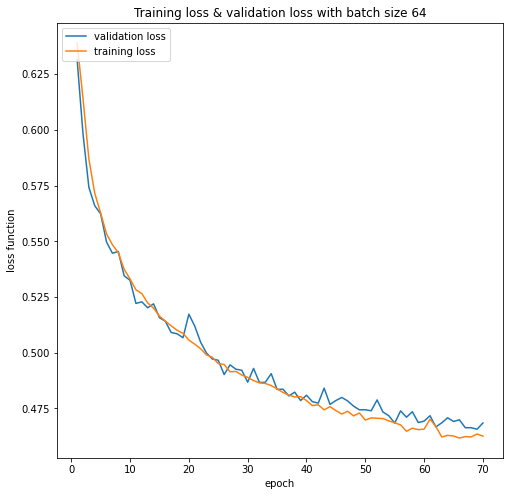

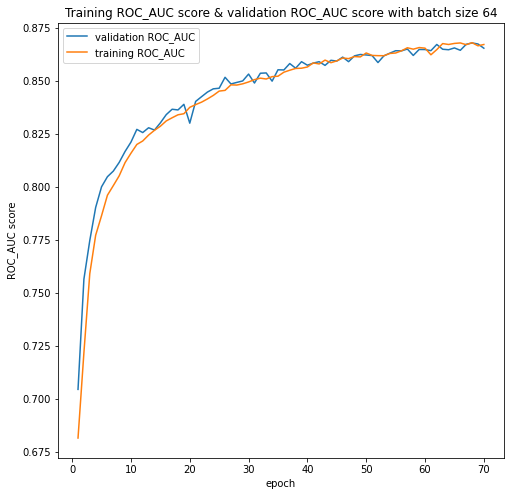

In [66]:
plot_performance(history_2)

### Predict the test data to evaluate the second model performance on kaggle competetion.

In [67]:
y_pred_2 = predict_and_make_submission_file(model_2,'sumbission_file_2.csv',batch_size = 64)
print(y_pred_2)

(12326, 1)
12326
[0.3936818  0.30167368 0.30114865 ... 0.19930197 0.18769689 0.82128865]


### Some intuitions about the second model's result

**Public roc_auc score: 84.835%, Private roc_auc score: 83.039%, avg roc_auc score:  83.937%**

Increasing the number of the hidden layer neurons here improves the ROC AUC score a little bit in both leaderboards and I think that is because of the increase in the number of trainable parameters, and note that there wasn't overfit happen here.

### Third trail
here I changed only in the configuration of the message passing style to **RGCN**, our model is primarily motivated as an extension of GCNs that operate on local graph neighborhoods to large-scale relational data to large-scale relational data (a linear transformation with a weight matrix), This type of transformation has been shown to be very effective at accumulating and encoding features from local, structured neighborhoods, and has led to significant improvements in areas such as graph classification, in this kind of problem I would see if this kind of mesaage pass style would imorove the accracy or the **GGNN** is better for this kind of problems

In [68]:
model_3 = build_GCN(hidden_dim = 32 ,message_calculation_class = 'RGCN' ,dense_intermediate_layer_activation = 'tanh', num_layers = 2)

model_3.summary()

message passing style used in this model will be RGCN

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)           [(

### Start compiling and training the third model

In [69]:
model_3, history_3 = compile_and_train_model(model_3, training_set, validation_set, 'adam', 'BinaryCrossentropy', 'AUC', 64, 70)

Epoch 1/70


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_1_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_1_grad/Identity:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/cond_1_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_grad/Identity:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/cond_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amoun

633/633 [==============================] - 14s 20ms/step - loss: 0.6582 - auc: 0.6475 - val_loss: 0.6473 - val_auc: 0.6676
Epoch 2/70
633/633 [==============================] - 13s 20ms/step - loss: 0.6398 - auc: 0.6808 - val_loss: 0.6325 - val_auc: 0.6944
Epoch 3/70
633/633 [==============================] - 12s 19ms/step - loss: 0.6319 - auc: 0.6914 - val_loss: 0.6284 - val_auc: 0.7050
Epoch 4/70
633/633 [==============================] - 12s 18ms/step - loss: 0.6208 - auc: 0.7133 - val_loss: 0.6030 - val_auc: 0.7516
Epoch 5/70
633/633 [==============================] - 13s 20ms/step - loss: 0.6034 - auc: 0.7396 - val_loss: 0.5988 - val_auc: 0.7502
Epoch 6/70
633/633 [==============================] - 12s 19ms/step - loss: 0.6015 - auc: 0.7423 - val_loss: 0.6041 - val_auc: 0.7496
Epoch 7/70
633/633 [==============================] - 12s 20ms/step - loss: 0.5996 - auc: 0.7436 - val_loss: 0.5968 - val_auc: 0.7514
Epoch 8/70
633/633 [==============================] - 12s 19ms/step - los

### Plotting the third model performance

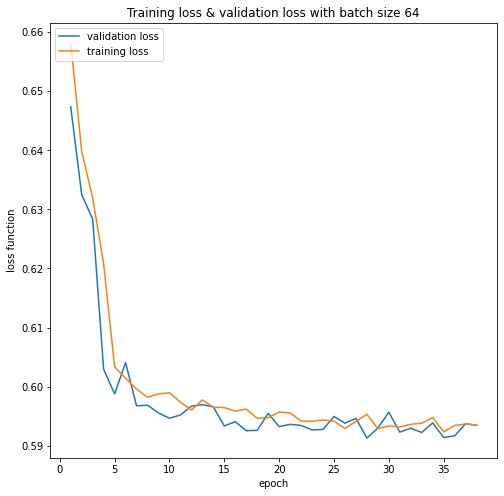

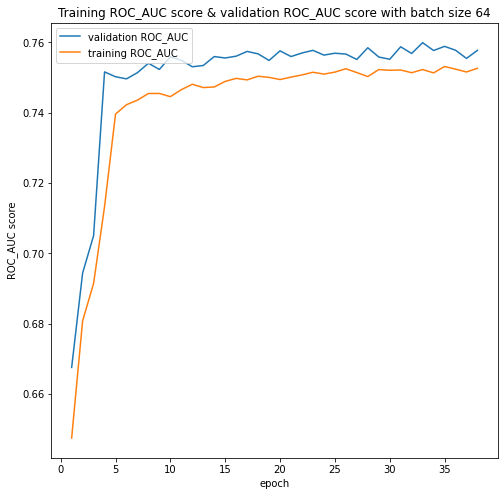

In [70]:
plot_performance(history_3)

### Predict the test data to evaluate the third model performance on kaggle competetion.

In [71]:
y_pred_3 = predict_and_make_submission_file(model_3,'sumbission_file_3.csv',batch_size = 64)

(12326, 1)
12326


### Some intuitions about the third model's result 

**Public ROC_AUC score: 74.639%, Private ROC_AUC score: 74.329%, avg ROC_AUC score: 74.484%**

Using this message passing style didn't help at all, **GGNN** was too much better the model and it overfits after training on the half epochs, so I don't recommend it for this kind of problem.

### Fourth trial

I this trial, I also changed the configuration of the message passing style to **GNN_Edge_MPL** it has the properties of the **RGCN** but it's a variant of **RGCN** in which messages on edges are computed using full MLPs, not just a single layer, and I choose it to compare its results with **RGCN** and I kept the other hyperparameters as default and I want to see if this would imporve the results and performance or not

In [72]:
model_4 = build_GCN(hidden_dim = 32 ,message_calculation_class = 'GNN_Edge_MLP' ,dense_intermediate_layer_activation = 'tanh', num_layers = 2)

model_4.summary()

message passing style used in this model will be GNN_Edge_MLP

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)     

### Start compiling and training the fourth model

In [73]:
model_4, history_4 = compile_and_train_model(model_4, training_set, validation_set, 'adam', 'BinaryCrossentropy', 'AUC', 64, 70)

Epoch 1/70


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_1_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_1_grad/Identity:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/cond_1_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_grad/Identity:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/cond_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amoun

633/633 [==============================] - 14s 20ms/step - loss: 0.6566 - auc: 0.6519 - val_loss: 0.6449 - val_auc: 0.6800
Epoch 2/70
633/633 [==============================] - 12s 19ms/step - loss: 0.6398 - auc: 0.6819 - val_loss: 0.6342 - val_auc: 0.7012
Epoch 3/70
633/633 [==============================] - 12s 19ms/step - loss: 0.6269 - auc: 0.7038 - val_loss: 0.6204 - val_auc: 0.7361
Epoch 4/70
633/633 [==============================] - 12s 19ms/step - loss: 0.6059 - auc: 0.7376 - val_loss: 0.6006 - val_auc: 0.7477
Epoch 5/70
633/633 [==============================] - 13s 20ms/step - loss: 0.6028 - auc: 0.7400 - val_loss: 0.5982 - val_auc: 0.7513
Epoch 6/70
633/633 [==============================] - 13s 20ms/step - loss: 0.6002 - auc: 0.7436 - val_loss: 0.5970 - val_auc: 0.7535
Epoch 7/70
633/633 [==============================] - 12s 19ms/step - loss: 0.5984 - auc: 0.7457 - val_loss: 0.5969 - val_auc: 0.7547
Epoch 8/70
633/633 [==============================] - 12s 19ms/step - los

### Plotting the fourth performance

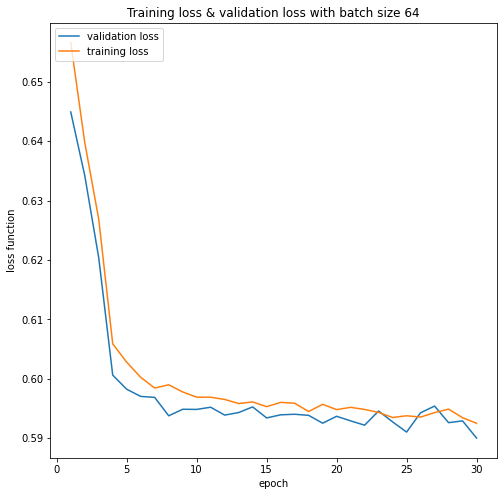

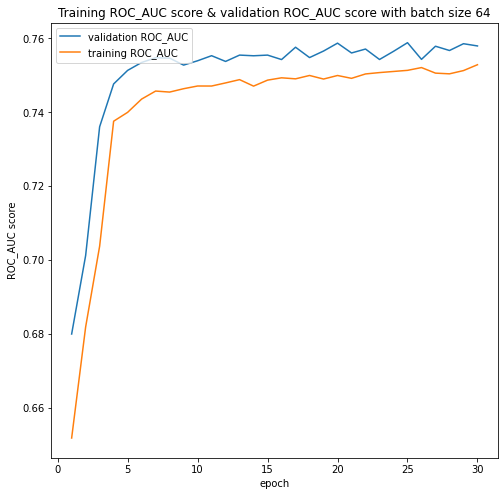

In [74]:
plot_performance(history_4)

### Predict the test data to evaluate the fourth model performance on kaggle competetion.

In [75]:
y_pred_4 = predict_and_make_submission_file(model_4,'sumbission_file_4.csv',batch_size = 64)
print(y_pred_4)

(12326, 1)
12326
[0.6021414  0.45127082 0.3075218  ... 0.28797185 0.35682538 0.48888752]


### Some intuitions about the fourth model's result 

**Public ROC_AUC score: 75.514%, Private ROC_AUC score: 74.699%, avg ROC_AUC score: 75.1065%**


Additional fully connect MLP in this archictechture helped a little bit than previous trial but not too much and I wouldn't recommend this model because it starts to overfit after 25 epochs and it's much worest than first and second trial.

### Fifth trial

In this trial, I used the **RGCN** as in the third trial but I decided to increase the number of hidden units to see if the number of weights when to increase it will improve the results or it will cause overfitting.

In [76]:
model_5 = build_GCN(hidden_dim = 64 ,message_calculation_class = 'RGCN' ,dense_intermediate_layer_activation = 'tanh', num_layers = 2)

model_5.summary()

message passing style used in this model will be RGCN

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)           [(

### Start compiling and training the fifth model

In [77]:
model_5, history_5 = compile_and_train_model(model_5, training_set, validation_set, 'adam', 'BinaryCrossentropy', 'AUC', 64, 70)

Epoch 1/70


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_1_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_1_grad/Identity:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradients/cond_1_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_grad/Identity:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradients/cond_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amoun

633/633 [==============================] - 14s 20ms/step - loss: 0.6509 - auc: 0.6598 - val_loss: 0.6377 - val_auc: 0.6779
Epoch 2/70
633/633 [==============================] - 12s 19ms/step - loss: 0.6356 - auc: 0.6833 - val_loss: 0.6318 - val_auc: 0.6913
Epoch 3/70
633/633 [==============================] - 12s 19ms/step - loss: 0.6312 - auc: 0.6937 - val_loss: 0.6260 - val_auc: 0.7091
Epoch 4/70
633/633 [==============================] - 12s 19ms/step - loss: 0.6184 - auc: 0.7179 - val_loss: 0.6021 - val_auc: 0.7526
Epoch 5/70
633/633 [==============================] - 12s 19ms/step - loss: 0.6016 - auc: 0.7441 - val_loss: 0.5978 - val_auc: 0.7541
Epoch 6/70
633/633 [==============================] - 13s 20ms/step - loss: 0.5978 - auc: 0.7469 - val_loss: 0.5950 - val_auc: 0.7540
Epoch 7/70
633/633 [==============================] - 13s 20ms/step - loss: 0.5975 - auc: 0.7470 - val_loss: 0.5934 - val_auc: 0.7559
Epoch 8/70
633/633 [==============================] - 12s 19ms/step - los

### Plotting the fifth model performance

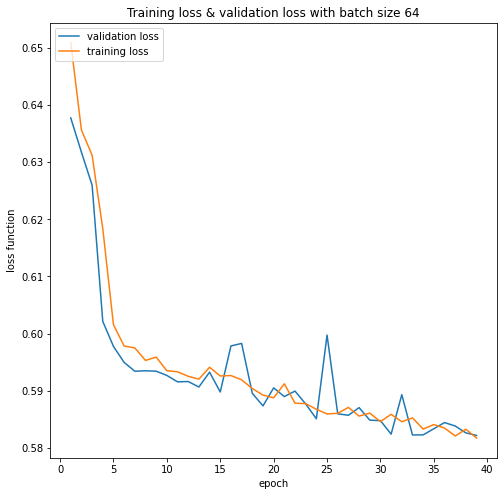

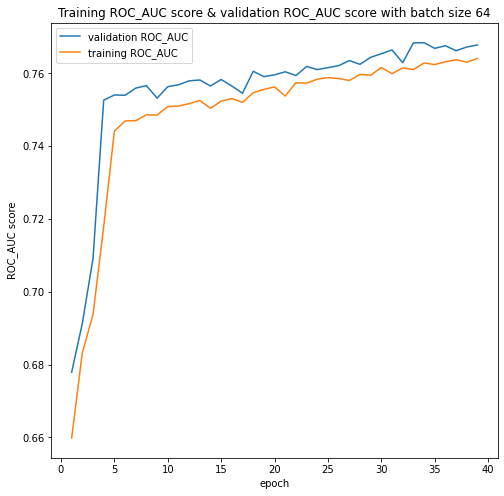

In [78]:
plot_performance(history_5)

### Predict the test data to evaluate the fifth model performance on kaggle competetion.

In [79]:
y_pred_5 = predict_and_make_submission_file(model_5,'sumbission_file_5.csv',batch_size = 64)
print(y_pred_5)

(12326, 1)
12326
[0.6386323  0.4338029  0.2667348  ... 0.24349347 0.36402273 0.6795052 ]


### Some intuitions about the fifth model's result 

**Public ROC_AUC score: 75.703%, Private ROC_AUC score: 75.188%, avg ROC_AUC score: 75.4455%**


It got a better result than **third trial** and the previous trial when I increased the number of **hidden_dim** but that didn't help too much and it's still much worest than **first** and **second trial**, the model starts overfitting after 35 epochs.

### Sixth trail

Here I did the same as the previous trial with same reason but with **GNN Edge MLP** message passing style and I will compare it with the previous trial.

In [80]:
model_6 = build_GCN(hidden_dim = 64 ,message_calculation_class = 'GNN_Edge_MLP' ,dense_intermediate_layer_activation = 'tanh', num_layers = 2)

model_6.summary()

message passing style used in this model will be GNN_Edge_MLP

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)     

### Start compiling and training the sixth model

In [ ]:
model_6, history_6 = compile_and_train_model(model_6, training_set, validation_set, 'adam', 'BinaryCrossentropy', 'AUC', 64, 70)

Epoch 1/70


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_1_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_1_grad/Identity:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradients/cond_1_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_grad/Identity:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradients/cond_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amoun

630/633 [============================>.] - ETA: 0s - loss: 0.6511 - auc: 0.6586

### Plotting the sixth model performance

In [ ]:
plot_performance(history_6)

### Predict the test data to evaluate the sixth model performance on kaggle competetion.

**Public ROC_AUC score: 74.878%, Private ROC_AUC score: 74.281%, avg ROC_AUC score: 74.5795%**


Increasing the number of **hidden_dim** for this gate wasn't good choice it got worest results than **fourth trial** and than **previous trial** which has 32 of **hidden_dim**, the start to overfit after only 14 epochs.

In [ ]:
y_pred_6 = predict_and_make_submission_file(model_6,'sumbission_file_6.csv',batch_size = 64)

### Some intuitions about the sixth model's result 

### Seventh trial

Here I decided to keep the hyperparameters as defaults except for the configuration of the message passing style parameter, I changed it to **RGAT** *(Relational Graph Attention Networks)*,This neural network operates on graph-structured data, using masked self-attentional layers to solve the drawbacks of previous approaches based on graph convolutions or their approximations. We enable (implicitly) providing various weights to distinct nodes in a neighborhood by stacking layers in which nodes can attend over their neighborhoods' attributes, without requiring any form of costly matrix operation (such as inversion) or relying on knowing the graph structure, so I use it to see if it'll help or not.

In [ ]:
model_7 = build_GCN(hidden_dim = 32 ,message_calculation_class = 'RGAT' ,dense_intermediate_layer_activation = 'tanh', num_layers = 2)

model_7.summary()

### Start compiling and training the seventh model

In [ ]:
model_7, history_7 = compile_and_train_model(model_7, training_set, validation_set, 'adam', 'BinaryCrossentropy', 'AUC', 64, 70)

### Plotting the seventh model performance

In [ ]:
plot_performance(history_7)

### Predict the test data to evaluate the seventh model performance on kaggle competetion.

It was better than GCN that used 

In [ ]:
y_pred_7 = predict_and_make_submission_file(model_7,'sumbission_file_7.csv',batch_size = 64)

### Some intuitions about the seventh model's result 

**Public ROC_AUC score: 77.694%, Private ROC_AUC score: 76.906%, avg ROC_AUC score: 77.3%**

it was better than models that used RGC and GNN_Edge_MLP as message_calculation_class hyperparameter but it's still much worest than previous model, the model start to overfit after 20 epochs.

### Eighth trial:

in this trial, I decided to back to use **GGNN** as **message_calculation_class** hyperparameter because it's the one which gave me best results but I'll change the number of layer from 4 (default value) to 8 to see if this would imorove the accuracy or it will produce overfitting.

In [ ]:
model_8 = build_GCN(hidden_dim = 32 ,message_calculation_class = 'GGNN' ,dense_intermediate_layer_activation = 'tanh', num_layers = 8)

model_8.summary()

### Start compiling and training the eigth model

In [ ]:
model_8, history_8 = compile_and_train_model(model_8, training_set, validation_set, 'adam', 'BinaryCrossentropy', 'AUC', 64, 70)

### Plotting the eighth model performance

In [ ]:
plot_performance(history_8)

### Predict the test data to evaluate the eighth model performance on kaggle competetion.

In [ ]:
y_pred_8 = predict_and_make_submission_file(model_8,'sumbission_file_8.csv',batch_size = 64)
print(y_pred_8)

### Some intuitions about the eigth model's result 

**Public ROC_AUC score: 85.387%, Private ROC_AUC score: 84.625%, avg ROC_AUC score: 85.006%**

the model gave me the best score till this moment and better than the **first trial** and the **second trial**, which use the same **message_calculation_class** as hyperparameter, the model start to overfit after 50 epoch which is better than previous trials. 

### The ninth trial (ideal solution)

As the previous layer but I increased the number of layer and I changed the intermediate layer activation function from **tanh** to **relu** to see if it will suffer from gradient vanishing or not. 

In [ ]:
model_9 = build_GCN(hidden_dim = 32 ,message_calculation_class = 'GGNN' ,dense_intermediate_layer_activation = 'relu', num_layers = 12)

model_9.summary()

### Start compiling and training the ninth model

In [ ]:
model_9, history_9 = compile_and_train_model(model_9, training_set, validation_set, 'adam', 'BinaryCrossentropy', 'AUC', 64, 70)

### Plotting the ninth model performance

In [ ]:
plot_performance(history_9)

### Predict the test data to evaluate the ninth model performance on kaggle competetion.

In [ ]:
y_pred_9 = predict_and_make_submission_file(model_9,'sumbission_file_9.csv',batch_size = 64)
print(y_pred_9)

### Some intuitions about the ninth model's result

**Public ROC_AUC score: 87.298%, Private ROC_AUC score:  86.195%, avg ROC_AUC score: 86.7465%**

much better score than all models that used **GGNN** as **message_calculation_class** hyperparameters and with best validation accuracy, and I think it's because the relu resisted to vanishing gradient problem.

### The tenth trial

In this trial, I exploded everything to increase the number of trainable parameters and to see if this model will overfit or the complexity of this model will help it to improve the accuracy over the previous trial. 


In [56]:
model_10 = build_GCN(hidden_dim = 128 ,message_calculation_class = 'GGNN' ,dense_intermediate_layer_activation = 'relu', num_layers = 14)

model_10.summary()

message passing style used in this model will be GGNN

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)           

### Start compiling and training the tenth model

In [57]:
model_10, history_10 = compile_and_train_model(model_10, training_set, validation_set, 'adam', 'BinaryCrossentropy', 'AUC', 64, 70)

Epoch 1/70


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/ggnn_13/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/ggnn_13/embedding_lookup_grad/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradients/ggnn_13/embedding_lookup_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/ggnn_12/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/ggnn_12/embedding_lookup_grad/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradients/ggnn_12/embedding_lookup_grad/Ca

633/633 [==============================] - 167s 245ms/step - loss: 0.6511 - auc: 0.6614 - val_loss: 0.6232 - val_auc: 0.7132
Epoch 2/70
633/633 [==============================] - 153s 241ms/step - loss: 0.6165 - auc: 0.7194 - val_loss: 0.6240 - val_auc: 0.7095
Epoch 3/70
633/633 [==============================] - 153s 242ms/step - loss: 0.6129 - auc: 0.7226 - val_loss: 0.6040 - val_auc: 0.7371
Epoch 4/70
633/633 [==============================] - 153s 242ms/step - loss: 0.6014 - auc: 0.7393 - val_loss: 0.5655 - val_auc: 0.7878
Epoch 5/70
633/633 [==============================] - 153s 241ms/step - loss: 0.5582 - auc: 0.7877 - val_loss: 0.5666 - val_auc: 0.7940
Epoch 6/70
633/633 [==============================] - 153s 242ms/step - loss: 0.5262 - auc: 0.8157 - val_loss: 0.5061 - val_auc: 0.8351
Epoch 7/70
633/633 [==============================] - 153s 242ms/step - loss: 0.4913 - auc: 0.8434 - val_loss: 0.4789 - val_auc: 0.8551
Epoch 8/70
633/633 [==============================] - 152s 

### Plotting the tenth model performance

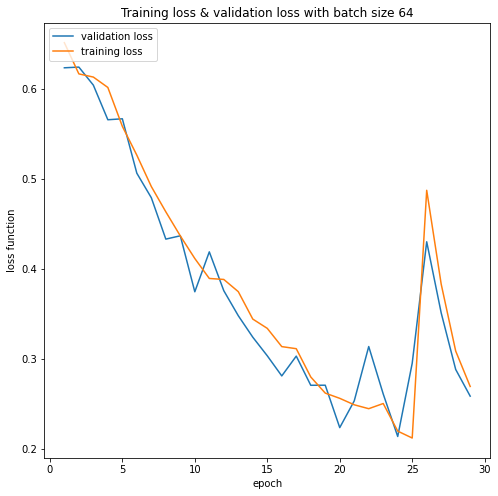

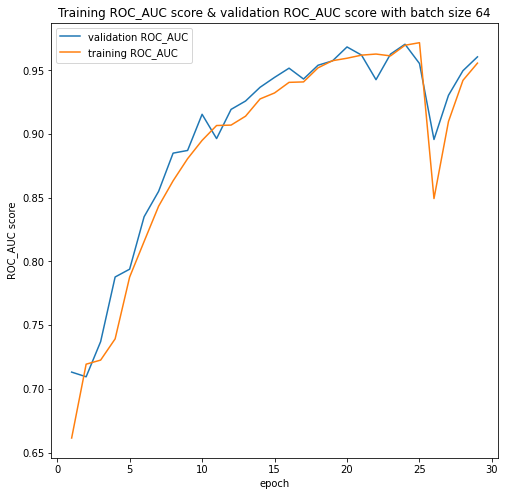

In [58]:
plot_performance(history_10)

### Predict the test data to evaluate the tenth model performance on kaggle competetion.

In [59]:
y_pred_10 = predict_and_make_submission_file(model_10,'sumbission_file_10.csv',batch_size = 64)
print(y_pred_10)

(12326, 1)
12326
[0.75058395 0.5506523  0.00405672 ... 0.00338916 0.1201865  0.4350401 ]


### Some intuitions about the tenth model's result.

**Public ROC_AUC score: 82.808%, Private ROC_AUC score:  80.928%, avg ROC_AUC score: 81.868%**


This model was the worest model with **message_calculation_class = 'GGNN'** as hyperparameter, and I think because it was deep neural model and that make the model capture the noisy obseravation and the made the model overfit at some point but the early stopping tracer stopped it before that happen.

the model start to overfit after **24 epoch**